In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_Yuming/codes')

Mounted at /content/drive


In [2]:
%%capture
!pip install ipython-autotime
!pip install torchdiffeq
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
%load_ext autotime
%matplotlib inline

time: 1.68 ms (started: 2021-07-12 20:34:30 +00:00)


In [3]:
import utils
from core_training import train_loop_diff, train_loop_em_new
from viz_loss import loss_grad_vis_1d, loss_grad_vis_2d
# from tqdm import tqdm
from tqdm.auto import tqdm

from models import DEModel, DAModel, NNModel, Noise

# reflect real-time changes in other modules
import importlib
importlib.reload(utils)
importlib.reload(DEModel)
importlib.reload(DAModel)
importlib.reload(NNModel)
importlib.reload(Noise)

from utils import Timer
import copy
import math
import random
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rc

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(f"device: {device}")

device: cpu
time: 7.19 s (started: 2021-07-12 20:34:30 +00:00)


In [4]:
importlib.reload(sys.modules['core_training'])
importlib.reload(NNModel)
importlib.reload(Noise)
importlib.reload(DAModel)
from core_training import train_loop_diff, train_loop_em_new


seed = 40
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# for nm in range(2):
x_dim = 40
true_F = 8.
true_coeff = torch.tensor([8., 0., 0., -1, 0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., 1., 0.], device=device)
true_ode_func = NNModel.Lorenz96(F=true_F, x_dim=x_dim, device=device).to(device)

init_m = torch.zeros(x_dim, device=device)
init_C_param = Noise.AddGaussian(x_dim, 50*torch.eye(x_dim), 'full').to(device)

train_and_test = 6
train_size = 4

with torch.no_grad():
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim), covariance_matrix=25 * torch.eye(x_dim)).sample().to(device) # <-
  t_warmup = torch.cat((torch.tensor([0.]), 120*torch.arange(1, train_and_test+1))).to(device)
  out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
  u0 = out_warmup[1:]  # (*bs, x_dim)

t0 = 0.
t_obs_step = 0.05
t_obs_end = 15.
t_obs = torch.arange(t0, t_obs_end+t_obs_step, t_obs_step)[1:].to(device)

model_Q_true = None

indices = [i for i in range(x_dim)] #if nm == 0 else ( [3 * i for i in range((x_dim-1)//3+1)] + [3 * i + 1 for i in range((x_dim+1)//3)] )
# indices = [3 * i for i in range((x_dim-1)//3+1)] + [3 * i + 1 for i in range((x_dim+1)//3)]
# indices = [2 * i for i in range(20)]
y_dim = len(indices)
time_varying_obs = False
if time_varying_obs:
  true_obs_func = []
  for j in range(t_obs.shape[0]):
    indices = np.random.choice(x_dim, y_dim, False)
    H_true = torch.eye(x_dim)[indices]
    true_obs_func.append(NNModel.Linear(x_dim, y_dim, H=H_true).to(device))
else:    
  H_true = torch.eye(x_dim)[indices]
  true_obs_func = NNModel.Linear(x_dim, y_dim, H=H_true).to(device)

noise_R_true = Noise.AddGaussian(y_dim, torch.tensor(1.), param_type='scalar').to(device)

with torch.no_grad():
  out, y_obs, out_intermediate, t_intermediate = DEModel.generate_data(true_ode_func, true_obs_func, t_obs, u0, model_Q_true, noise_R_true, 
                                                device=device, ode_method='rk4', ode_options=dict(step_size=0.01), adjoint=False, save_intermediate_step=True, t0=0., time_varying_obs=time_varying_obs)
  

enkf_kwargs = dict(ode_method='rk4', ode_options=dict(step_size=0.01), adjoint=True, adjoint_method='rk4', adjoint_options=dict(step_size=0.05),save_intermediate_step=True, smooth_lag=0, t0=t0, 
          var_inflation=None, localization_radius=5, compute_likelihood=True, likelihood_warmup=0, 
          linear_obs=True, time_varying_obs=time_varying_obs, save_first=True, simulation_type=0)

with torch.no_grad():
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim), covariance_matrix=25 * torch.eye(x_dim)).sample((50,)).to(device) # <-
  t_warmup = torch.cat((torch.tensor([0.]), torch.arange(80.,500.,20.))).to(device)
  out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
  u0_test = out_warmup[1:].reshape(-1,x_dim)  # (*bs, x_dim)
  print(u0_test.shape)

def monitor(ode_func, model_Q_param,noise_R_param, neg_log_likelihood, test_neg_log_likelihood, test_mse, fs, nll_suro_em, algorithm, device):
  res = torch.zeros(0, device=device)
  res = torch.cat((res, torch.sqrt(utils.mse_loss(ode_func.coeff, true_coeff)*18).detach().clone().view(-1)))
  res = torch.cat((res, ode_func.coeff.detach().clone().view(-1)))
  # res = torch.cat((res, torch.diagonal(model_Q_param.q_true()).detach().clone().view(-1)))
  # res = torch.cat((res, model_Q_param.q_true().detach().clone().view(-1)))
  res = torch.cat((res, torch.sqrt(torch.trace(model_Q_param.full())/x_dim).detach().clone().view(-1)))
  res = torch.cat((res, neg_log_likelihood.mean().detach().clone().view(-1)))
  res = torch.cat((res, test_neg_log_likelihood.mean().detach().clone().view(-1)))
  res = torch.cat((res, test_mse.mean().detach().clone().view(-1)))
  res = torch.cat((res, fs.detach().clone().view(-1)))
  return res.unsqueeze(dim=0)

coeff_list = torch.zeros(18,device=device).unsqueeze(0).repeat(1,1)
Q_list = 2*torch.ones(x_dim, device=device).unsqueeze(0).repeat(1,1)

n_runs=4
test_epochs=1000

N_ensem = 50
save = False
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/"
prefix = f"N_{N_ensem}_x_{x_dim}_y_{y_dim}_"



# lambda1 = lambda epoch: (epoch-9)**(-0.5) if epoch >=10 else 1
# lambda2 = lambda epoch: (epoch-9)**(-0.5) if epoch >=10 else 1

# enkf_kwargs['likelihood_warmup']=20
# monitor_EnKF = torch.zeros(0, device=device)
# for iter in range(n_runs):#iter in range(1): 
#   print(f"iter={iter}")
#   learned_ode_func = NNModel.Lorenz96_dict_param(coeff_list[0].detach().clone(), device, x_dim).to(device)
#   learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
#   # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim,device=device), 'tril').to(device)
#   optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1},
#                             {'params':learned_model_Q.parameters(), 'lr':1e-1}])
#   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.3)
#   # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.99)
#   # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,50,100], gamma=0.3)
#   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lambda epoch: 0.99 if epoch >= 10 else 1, lambda epoch: 0.99 if epoch >= 10 else 1])
#   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
#   monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, n_epochs=150, 
#                                 scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=50, test_every_n_epochs=test_epochs, tbptt=20, method='enkf', train_size=train_size, clip_norm=None, 
#                                 true_system="L96", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
#   monitor_EnKF = torch.cat((monitor_EnKF, monitor_res.unsqueeze(0)))
# if save:
#   torch.save({'monitor': monitor_EnKF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EnKF")
#   with open(save_location+prefix+"EnKF.txt",'ab') as f:
#     np.savetxt(f, utils.mean_and_std(monitor_EnKF[:,-1,0]))
#     np.savetxt(f, utils.mean_and_std(torch.abs(monitor_EnKF[:,-1,1]-true_coeff[0])))
#     np.savetxt(f, utils.mean_and_std(torch.sqrt(torch.sum((monitor_EnKF[:,-1,2:19]-true_coeff[1:18])**2, dim=-1))))

# lambda1 = lambda epoch: (epoch-9)**(-1) if epoch >=10 else 1

# enkf_kwargs['likelihood_warmup']=20
# enkf_kwargs['smooth_lag']=0
# monitor_EM = torch.zeros(0, device=device)
# for iter in range(n_runs):
#   print(f"iter={iter}")
#   learned_ode_func = NNModel.Lorenz96_dict_param(coeff_list[0].detach().clone(), device, x_dim).to(device)
#   learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
#   # learned_model_Q = utils.softplus_inv(0.1*torch.ones(x_dim, device=device))
#   optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1}])
#                             #  {'params':learned_model_Q.parameters(), 'lr':1e-1}])
#   # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1}])
#   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lambda epoch: 0.95 if epoch >= 10 else 1])
#   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
#   # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.95)
#   monitor_res,learned_model_Q = train_loop_em_new(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, n_epochs=150, 
#                               scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=50, test_every_n_epochs=test_epochs, train_size=train_size, m_step_type="mean", m_steps=3,
#                               track_Q='diag', true_system="L96", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
#   monitor_EM = torch.cat((monitor_EM, monitor_res.unsqueeze(0)))
# if save:
#   torch.save({'monitor': monitor_EM, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EM")
#   with open(save_location+prefix+"EM.txt",'ab') as f:
#     np.savetxt(f, utils.mean_and_std(monitor_EM[:,-1,0]))
#     np.savetxt(f, utils.mean_and_std(torch.abs(monitor_EM[:,-1,1]-true_coeff[0])))
#     np.savetxt(f, utils.mean_and_std(torch.sqrt(torch.sum((monitor_EM[:,-1,2:19]-true_coeff[1:18])**2, dim=-1))))


# lambda1 = lambda epoch: (epoch-9)**(-0.5) if epoch >=10 else 1
# lambda2 = lambda epoch: (epoch-9)**(-0.5) if epoch >=10 else 1
# enkf_kwargs['likelihood_warmup']=20
# monitor_PF = torch.zeros(0, device=device)
# for iter in range(n_runs):#iter in range(1): 
#   print(f"iter={iter}")
#   learned_ode_func = NNModel.Lorenz96_dict_param(coeff_list[0].detach().clone(), device, x_dim).to(device)
#   learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
#   # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim,device=device), 'tril').to(device)
#   optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1},
#                             {'params':learned_model_Q.parameters(), 'lr':1e-1}])
#   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.3)
#   # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.99)
#   # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.3)
#   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lambda epoch: 0.9 if epoch >= 10 else 1, lambda epoch: 0.9 if epoch >= 10 else 1])
#   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
#   monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, n_epochs=150, 
#                                 scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=50, test_every_n_epochs=test_epochs, tbptt=20, method='pf', train_size=train_size, clip_norm=None, 
#                                 true_system="L96", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
#   monitor_PF = torch.cat((monitor_PF, monitor_res.unsqueeze(0)))
# if save:
#   torch.save({'monitor': monitor_PF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"PF")
#   with open(save_location+prefix+"PF.txt",'ab') as f:
#     np.savetxt(f, utils.mean_and_std(monitor_PF[:,-1,0]))
#     np.savetxt(f, utils.mean_and_std(torch.abs(monitor_PF[:,-1,1]-true_coeff[0])))
#     np.savetxt(f, utils.mean_and_std(torch.sqrt(torch.sum((monitor_PF[:,-1,2:19]-true_coeff[1:18])**2, dim=-1))))


torch.Size([1050, 40])
time: 6.4 s (started: 2021-07-12 20:35:17 +00:00)


In [5]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_EnKF")
monitor_EnKF = d_EnKF['monitor']
d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_EM")
monitor_EM = d_EM['monitor']
d_PF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_PF")
monitor_PF = d_PF['monitor']

time: 1.72 s (started: 2021-07-12 20:36:56 +00:00)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


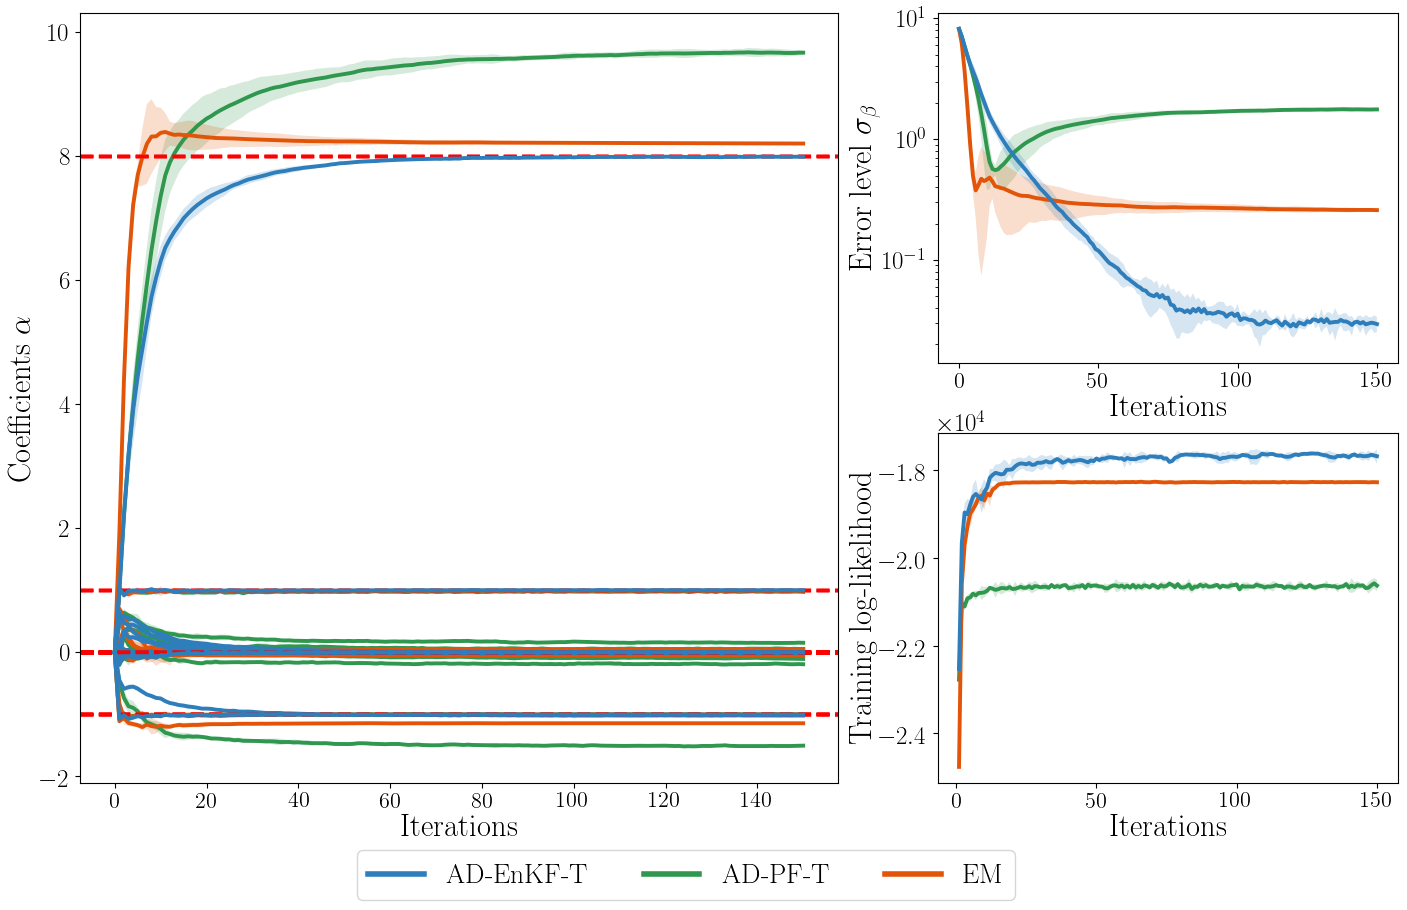

time: 4.78 s (started: 2021-07-12 20:37:10 +00:00)


In [6]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
mpl.rcParams['axes.grid']= False
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 18
mpl.rcParams['legend.fontsize']= 20

true_coeff = torch.tensor([8., 0., 0., -1, 0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., 1., 0.], device=device)


def custom_axes(axes, ax_d):
  
  ax_d[0].set_xlabel(r"Iterations")
  ax_d[1].set_xlabel(r"Iterations")
  ax_d[2].set_xlabel(r"Iterations")
  ax_d[0].set_ylabel(r"Coefficients $\alpha$")
  ax_d[1].set_ylabel(r"Error level $\sigma_\beta$")
  ax_d[2].set_ylabel(r"Training log-likelihood")
  # ax_d[2].tick_params(axis='y', which='major', labelsize=12)
  ax_d[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
  # ax_d[2].set_ylim(-44000,-34800)
  # handles, labels = utils.unique_labels(ax_d[2])
  # legend_order=[0,1]
  # ax_d[2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')

  ax_d[1].get_legend().remove()
  handles, labels = utils.unique_labels(ax_d[0])
  leg=ax_d[0].legend(handles, labels, loc='lower center',bbox_to_anchor=(0.8, -0.17), ncol=3)
  ax_d[2].get_legend().remove()
  for line in leg.get_lines():
    line.set_linewidth(4.0)
  
  return

# monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()



save_location=None
load_location=None
# save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/param_est_resize"
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = [monitor_PF_new,monitor_EM_new,monitor_EnKF_new]#,monitor_PF-monitor_KF]
methods = [ r"AD-PF-T",r"EM",r"AD-EnKF-T"]
titles = [None] * 20
# truths = [None] * 20
truths = [None, *true_coeff.tolist()] + [None] * 20
truths_legends = None
truths2 = [None] * 20
truths2_legends = None
colors_list = [cm.Greens, cm.Oranges, cm.Blues]

groups = [(1,19)]
plots_to_show = [1, 0, 3]
logscale={1}#{0,1,2}
logscalex={}
legend_order=[0,1,2]
subplot_groups=((0,2),(0,2))
ax_d = {1:(0,2), 2:(1,2)}
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, plot_truth_first=True,start_from_one={2}, legend_order=legend_order, groups=groups,
                           gridspec_kw={'width_ratios': [1, 1,1.4]},subplots_adjust=0.27,error_bar=True, error_bar_style="std", n_cols=3,subplot_width=17/3, subplot_height=5, subplot_groups=subplot_groups, ax_d=ax_d,linewidth=2.8, colors_list=colors_list, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

In [11]:
a = torch.arange(18)

b=torch.tensor([1,4,12,17])
a[b]

tensor([ 1,  4, 12, 17])

time: 12.7 ms (started: 2021-07-12 20:47:42 +00:00)


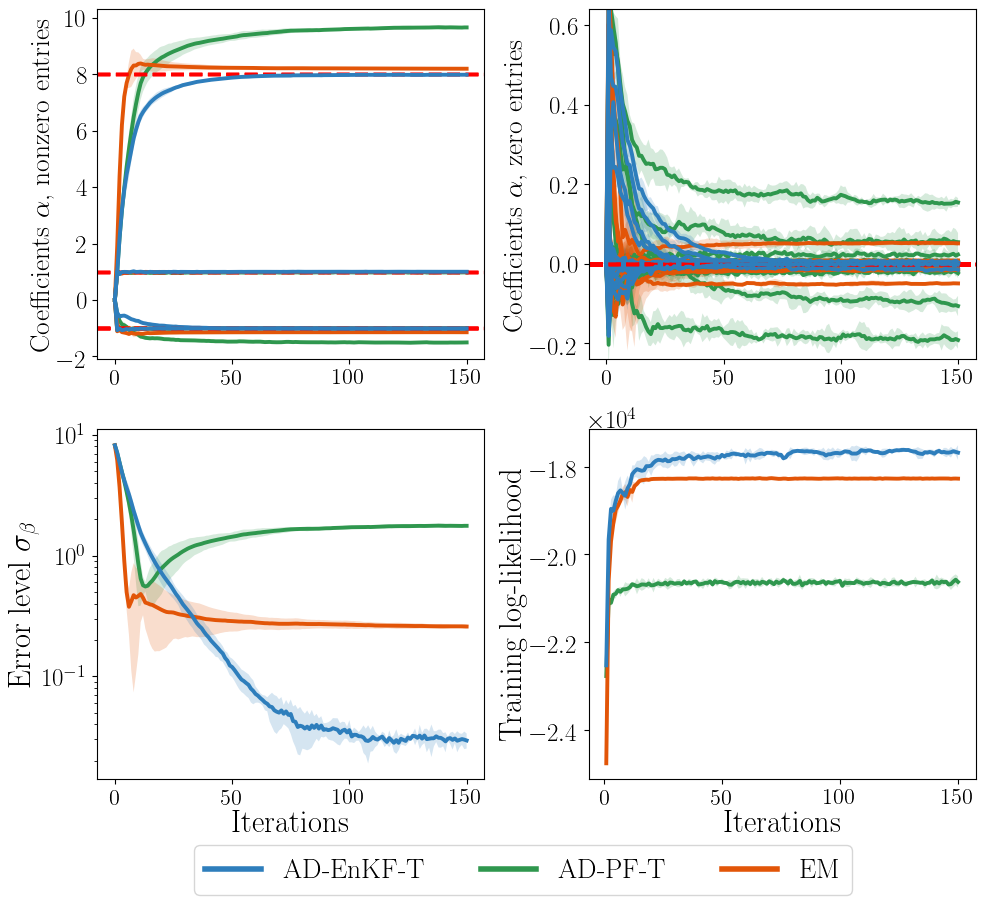

time: 2.67 s (started: 2021-07-12 21:07:40 +00:00)


In [35]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
mpl.rcParams['axes.grid']= False
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 18
mpl.rcParams['legend.fontsize']= 20

true_coeff = torch.tensor([8., 0., 0., -1, 0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., 1., 0.], device=device)


def custom_axes(axes, ax_d):
  
  # ax_d[0].set_xlabel(r"Iterations")
  # ax_d[1].set_xlabel(r"Iterations")
  ax_d[2].set_xlabel(r"Iterations")
  ax_d[3].set_xlabel(r"Iterations")
  ax_d[0].set_ylabel(r"Coefficients $\alpha$, nonzero entries", fontsize=20)
  ax_d[1].set_ylabel(r"Coefficients $\alpha$, zero entries", fontsize=20)
  utils.set_lim_ticks(ax_d[1], -0.2, 0.6, 5)
  ax_d[2].set_ylabel(r"Error level $\sigma_\beta$")
  ax_d[3].set_ylabel(r"Training log-likelihood")
  # ax_d[3].tick_params(axis='y', which='major', labelsize=12)
  ax_d[3].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
  # ax_d[2].set_ylim(-44000,-34800)
  # handles, labels = utils.unique_labels(ax_d[2])
  # legend_order=[0,1]
  # ax_d[2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')

  ax_d[0].get_legend().remove()
  ax_d[1].get_legend().remove()
  handles, labels = utils.unique_labels(ax_d[2])
  leg=ax_d[2].legend(handles, labels, loc='lower center',bbox_to_anchor=(1.1, -0.37), ncol=3)
  ax_d[3].get_legend().remove()
  for line in leg.get_lines():
    line.set_linewidth(4.0)
  
  return

# monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
i1 = torch.tensor([1,4,12,17])
i2 = torch.tensor([2,3,5,6,7,8,9,10,11,13,14,15,16,18])
monitor_EnKF_new[:,:,1:5]=monitor_EnKF[:,:,i1].detach().clone()
monitor_EnKF_new[:,:,5:19]=monitor_EnKF[:,:,i2].detach().clone()
monitor_PF_new[:,:,1:5]=monitor_PF[:,:,i1].detach().clone()
monitor_PF_new[:,:,5:19]=monitor_PF[:,:,i2].detach().clone()
monitor_EM_new[:,:,1:5]=monitor_EM[:,:,i1].detach().clone()
monitor_EM_new[:,:,5:19]=monitor_EM[:,:,i2].detach().clone()

save_location=None
load_location=None
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/param_est_resize_split"
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = [monitor_PF_new,monitor_EM_new,monitor_EnKF_new]#,monitor_PF-monitor_KF]
methods = [ r"AD-PF-T",r"EM",r"AD-EnKF-T"]
titles = [None] * 20
# truths = [None] * 20
truths = [None, 8, -1, -1, 1] + [0] * 14 + [None] * 20
truths_legends = None
truths2 = [None] * 20
truths2_legends = None
colors_list = [cm.Greens, cm.Oranges, cm.Blues]

groups = [(1,5),(5,19)]
plots_to_show = [1, 2, 0, 4]
logscale={2}#{0,1,2}
logscalex={}
legend_order=[0,1,2]
subplot_groups=None#((0,2),(0,2))
ax_d = None#{1:(0,2), 2:(1,2)}
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, plot_truth_first=True,start_from_one={3}, legend_order=legend_order, groups=groups,
                           gridspec_kw=None,subplots_adjust=0.27,error_bar=True, error_bar_style="std", n_cols=2,subplot_width=17/3, subplot_height=5, subplot_groups=subplot_groups, ax_d=ax_d,linewidth=2.8, colors_list=colors_list, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

In [ ]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96/N_50_x_40_y_40_EnKF")
monitor_EnKF = d_EnKF['monitor']
d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96/N_50_x_40_y_40_EM")
monitor_EM = d_EM['monitor']

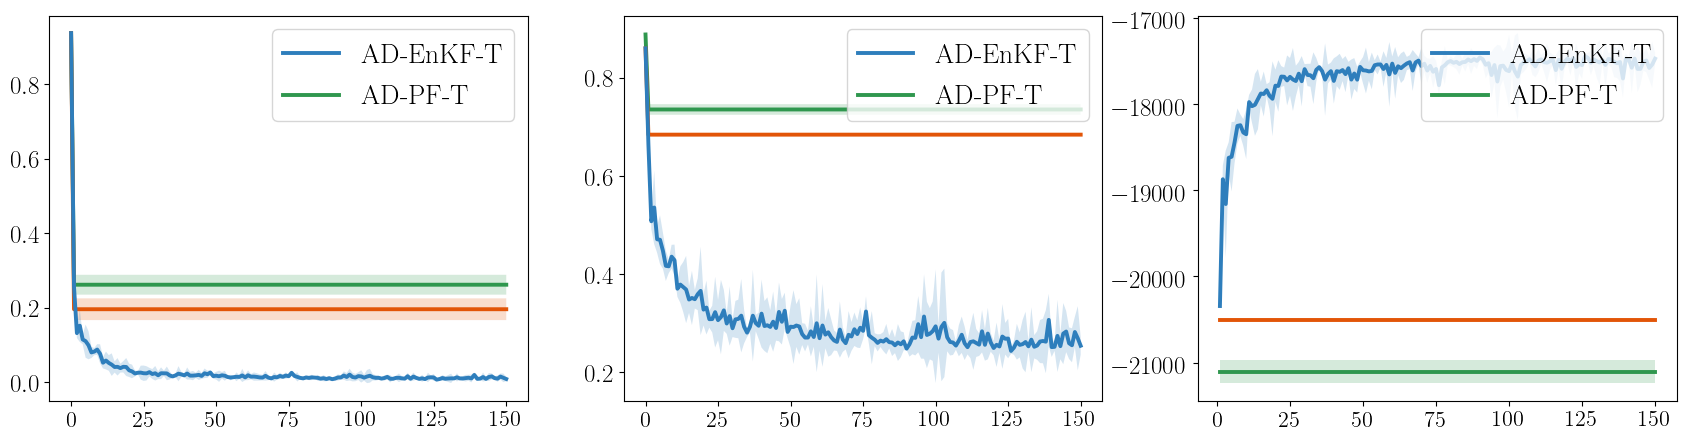

time: 691 ms (started: 2021-06-24 18:49:31 +00:00)


In [ ]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
mpl.rcParams['axes.grid']= False
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 18
mpl.rcParams['legend.fontsize']= 20

true_coeff = torch.tensor([8., 0., 0., -1, 0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., 1., 0.], device=device)


def custom_axes(axes, ax_d):
  
  # ax_d[0].set_xlabel(r"Iterations")
  # ax_d[1].set_xlabel(r"Iterations")
  # ax_d[2].set_xlabel(r"Iterations")
  # ax_d[0].set_ylabel(r"Coefficients $\alpha$")
  # ax_d[1].set_ylabel(r"Error level $\sigma_\beta$")
  # ax_d[2].set_ylabel(r"Training log-likelihood")
  # # ax_d[2].tick_params(axis='y', which='major', labelsize=12)
  # ax_d[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
  # # ax_d[2].set_ylim(-44000,-34800)
  # # handles, labels = utils.unique_labels(ax_d[2])
  # # legend_order=[0,1]
  # # ax_d[2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')

  # ax_d[1].get_legend().remove()
  # handles, labels = utils.unique_labels(ax_d[0])
  # leg=ax_d[0].legend(handles, labels, loc='lower center',bbox_to_anchor=(0.8, -0.17), ncol=3)
  # ax_d[2].get_legend().remove()
  # for line in leg.get_lines():
    # line.set_linewidth(4.0)

  return

monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
# monitor_EnKF_new = torch.cat((monitor_EnKF_new, torch.zeros_like(monitor_EnKF_new[:,0:1,1:19])), dim=-2)
# monitor_EM_new = torch.cat((monitor_EM_new, torch.zeros_like(monitor_EM_new[:,0:1,1:19])), dim=-2)
# monitor_EM_new = torch.cat((monitor_EM_new, utils.flat2matrix(monitor_EM_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EnKF_new[:,:,0]=torch.abs(monitor_EnKF_new[:,:,0]-monitor_KF_truths[0])


save_location=None
load_location=None
# save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96/param_est"
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

monitor_res = [monitor_PF_new,monitor_EM_new,monitor_EnKF_new]#,monitor_PF-monitor_KF]
methods = [ r"AD-PF-T",r"EM",r"AD-EnKF-T"]
titles = [None] * 20
# truths = [None] * 20
truths = [None, *true_coeff.tolist()] + [None] * 20
truths_legends = None
truths2 = [None] * 20
truths2_legends = None
colors_list = [cm.Greens, cm.Oranges, cm.Blues]

groups = [(1,19)]
plots_to_show = [6,5,4]
logscale={}#{0,1,2}
logscalex={}
legend_order=[0,1]
subplot_groups=None#((0,2),(0,2))
ax_d = {1:(0,2), 2:(1,2)}
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, plot_truth_first=True, start_from_one={2}, legend_order=legend_order, groups=groups,
                           error_bar=True, error_bar_style="std", n_cols=3,subplot_width=7, subplot_height=5, subplot_groups=subplot_groups, ax_d=ax_d,linewidth=2.8, colors_list=colors_list, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

In [ ]:
utils.mean_and_std(monitor_EnKF[:,-1,0])#monitor_EnKF_new[:,-1,0]

(0.04102247, 0.000700767)

time: 8.1 ms (started: 2021-05-30 01:35:11 +00:00)
